In [ ]:
# ====================================================================
# PHẦN 1: CÀI ĐẶT THƯ VIỆN VÀ CHUẨN BỊ DỮ LIỆU (CHƯƠNG 2)
# ====================================================================

print("--- 1. Cài đặt Thư viện cần thiết (Có thể mất 1-2 phút) ---")
!pip install underthesea wordcloud matplotlib seaborn pandas numpy scikit-learn -q
!pip install sentence-transformers -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import word_tokenize
from wordcloud import WordCloud

# Thư viện Học máy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer

# Thiết lập hiển thị
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120
try:
    plt.rcParams['font.family'] = 'DejaVu Sans'
except:
    pass

# Đọc dữ liệu (Đảm bảo file đã được tải lên Colab)
try:
    df_train = pd.read_csv('synthetic_train.csv')
    df_val = pd.read_csv('synthetic_val.csv')
    print("✅ Đọc dữ liệu thành công.")
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file dữ liệu. Vui lòng tải 'synthetic_train.csv' và 'synthetic_val.csv' lên Colab.")
    exit()

# Khởi tạo Label Encoder và tách dữ liệu
le = LabelEncoder()
df_train['sentiment_encoded'] = le.fit_transform(df_train['sentiment'])
df_val['sentiment_encoded'] = le.transform(df_val['sentiment'])

X_train, y_train = df_train['sentence'], df_train['sentiment_encoded']
X_val, y_val = df_val['sentence'], df_val['sentiment_encoded']

# Định nghĩa Stopwords tiếng Việt cơ bản
VIETNAMESE_STOPWORDS = set([
    'và', 'của', 'là', 'các', 'cái', 'tôi', 'này', 'mình', 'những', 'một', 'được', 'có', 'rất',
    'với', 'không', 'em', 'anh', 'chị', 'thì', 'mà', 'nên', 'cũng', 'đã', 'sẽ', 'từ', 'vào', 'ở',
    'cho', 'để', 'vì', 'như', 'khi', 'sau', 'trước', 'bên', 'dưới', 'trên', 'qua'
])

# Hàm tiền xử lý (Tokenizer)
def vietnamese_tokenizer(text):
    tokens = word_tokenize(str(text).lower(), format="text")
    words = [token for token in tokens.split() if token not in VIETNAMESE_STOPWORDS and token.isalpha()]
    return words

--- 1. Cài đặt Thư viện cần thiết (Có thể mất 1-2 phút) ---
✅ Đọc dữ liệu thành công.



--- 2. Tạo Hình ảnh EDA (Mục 1.3) ---


/tmp/ipython-input-4191001772.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df_train,


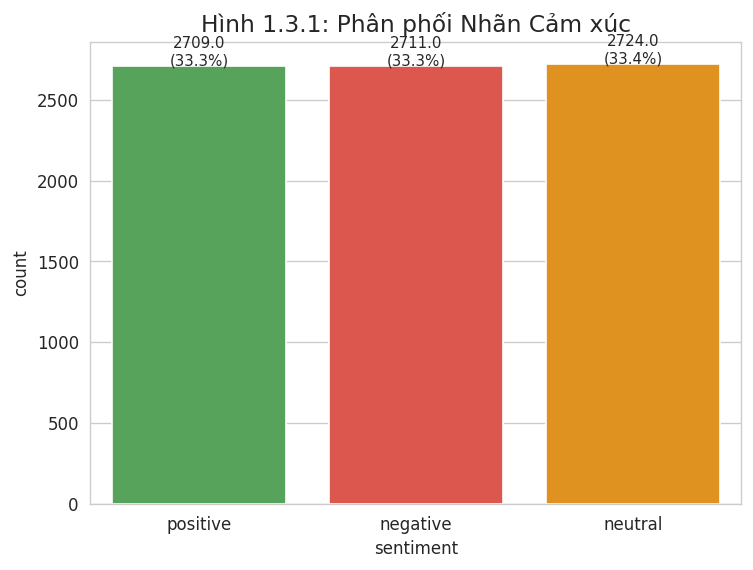

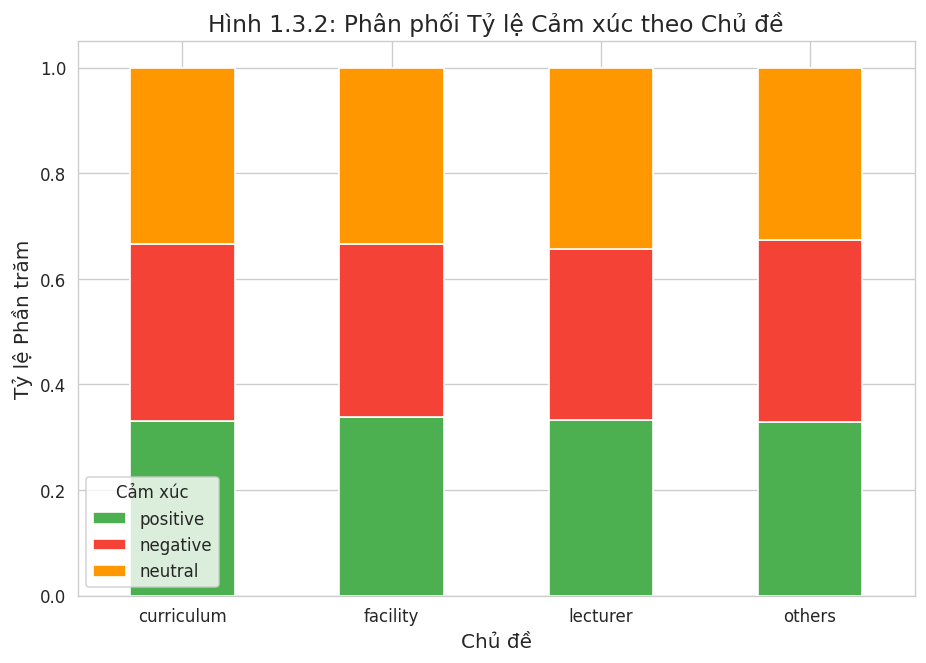

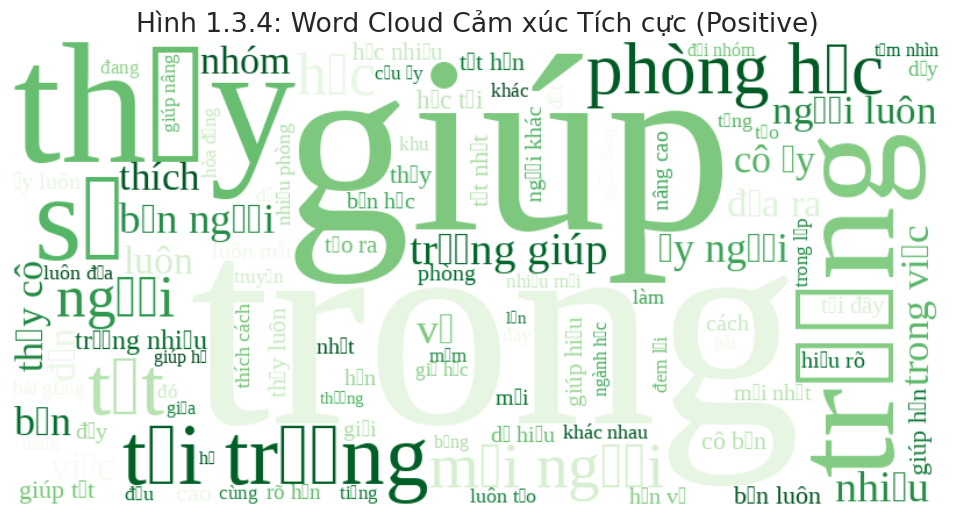

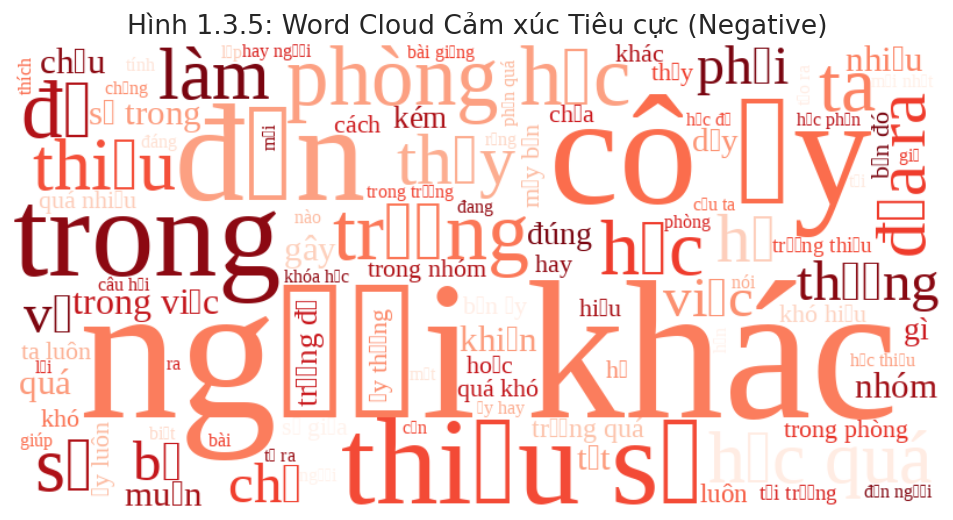

In [ ]:
# ====================================================================
# PHẦN 2: EDA & TRỰC QUAN HÓA (Tạo hình ảnh cho Mục 1.3)
# ====================================================================

print("\n--- 2. Tạo Hình ảnh EDA (Mục 1.3) ---")

df_train['word_count'] = df_train['sentence'].apply(lambda x: len(word_tokenize(str(x))))

# --- HÌNH 1.3.1: PHÂN PHỐI NHÃN CẢM XÚC ---
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='sentiment', data=df_train,
                   order=['positive', 'negative', 'neutral'],
                   palette=['#4CAF50', '#F44336', '#FF9800'])
plt.title('Hình 1.3.1: Phân phối Nhãn Cảm xúc', fontsize=14)
total = len(df_train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{height}\n({height/total:.1%})', ha="center", fontsize=9)
plt.show()


# --- HÌNH 1.3.2: PHÂN PHỐI CẢM XÚC THEO CHỦ ĐỀ (Dữ liệu bổ sung) ---
sentiment_by_topic = df_train.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_topic_percent = sentiment_by_topic.apply(lambda x: x / x.sum(), axis=1)

sentiment_by_topic_percent[['positive', 'negative', 'neutral']].plot(
    kind='bar', stacked=True, figsize=(9, 6),
    color=['#4CAF50', '#F44336', '#FF9800']
)
plt.title('Hình 1.3.2: Phân phối Tỷ lệ Cảm xúc theo Chủ đề', fontsize=14)
plt.xlabel('Chủ đề', fontsize=12)
plt.ylabel('Tỷ lệ Phần trăm', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Cảm xúc', loc='lower left')
plt.show()


# --- HÌNH 1.3.4 & 1.3.5: WORD CLOUDS (Tần suất từ ngữ) ---
def preprocess_for_wc(text):
    tokens = word_tokenize(str(text).lower())
    words = [token for token in tokens if token.isalpha() and token not in VIETNAMESE_STOPWORDS]
    return ' '.join(words)

df_train['processed_sentence_wc'] = df_train['sentence'].apply(preprocess_for_wc)

def create_wordcloud_plot(text_data, title, color_map):
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', max_words=100,
        colormap=color_map, font_path='/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf'
    ).generate(text_data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

positive_text_wc = " ".join(df_train[df_train['sentiment'] == 'positive']['processed_sentence_wc'].tolist())
create_wordcloud_plot(positive_text_wc, 'Hình 1.3.4: Word Cloud Cảm xúc Tích cực (Positive)', 'Greens')

negative_text_wc = " ".join(df_train[df_train['sentiment'] == 'negative']['processed_sentence_wc'].tolist())
create_wordcloud_plot(negative_text_wc, 'Hình 1.3.5: Word Cloud Cảm xúc Tiêu cực (Negative)', 'Reds')


--- 3. Thực nghiệm và Kết quả (Chương 3) ---

[3.2.1] Vector hóa BoW...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



[3.2.2] Vector hóa TF-IDF...

[3.2.3] Sentence Embeddings (Quá trình này có thể mất 1-2 phút)...


Batches:   0%|          | 0/255 [00:00<?, ?it/s]

Batches:   0%|          | 0/64 [00:00<?, ?it/s]


[3.2] Chạy các thuật toán (LR, SVC) cho 3 bộ đặc trưng...

------------------------------------------------------------------------------------------------
🏆 BẢNG KẾT QUẢ SO SÁNH HIỆU SUẤT (Mục 3.2.6) 🏆
| Vectorizer   | Model   |   Accuracy |   F1_Macro |   Precision_Wgt |   Recall_Wgt |
|:-------------|:--------|-----------:|-----------:|----------------:|-------------:|
| Embeddings   | SVC     |     0.8089 |     0.8075 |          0.8079 |       0.8089 |
| Embeddings   | LR      |     0.8055 |     0.8036 |          0.8037 |       0.8055 |
| BoW          | LR      |     0.7171 |     0.7195 |          0.7267 |       0.7171 |
| TF-IDF       | LR      |     0.7127 |     0.7132 |          0.7164 |       0.7127 |
| TF-IDF       | SVC     |     0.7092 |     0.7105 |          0.7143 |       0.7092 |
| BoW          | SVC     |     0.7038 |     0.706  |          0.712  |       0.7038 |
------------------------------------------------------------------------------------------------


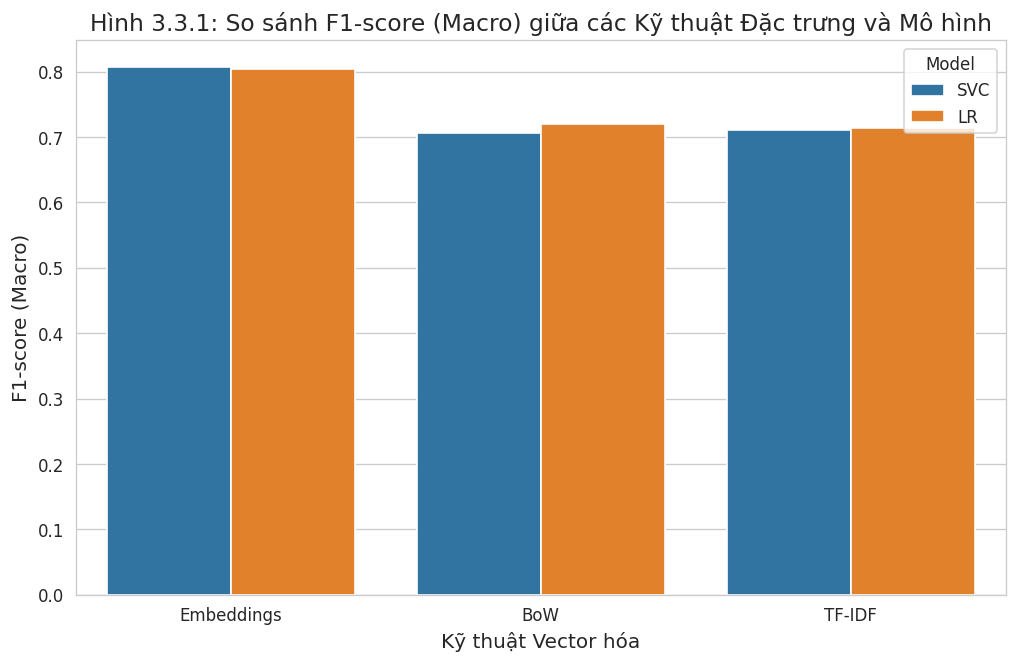

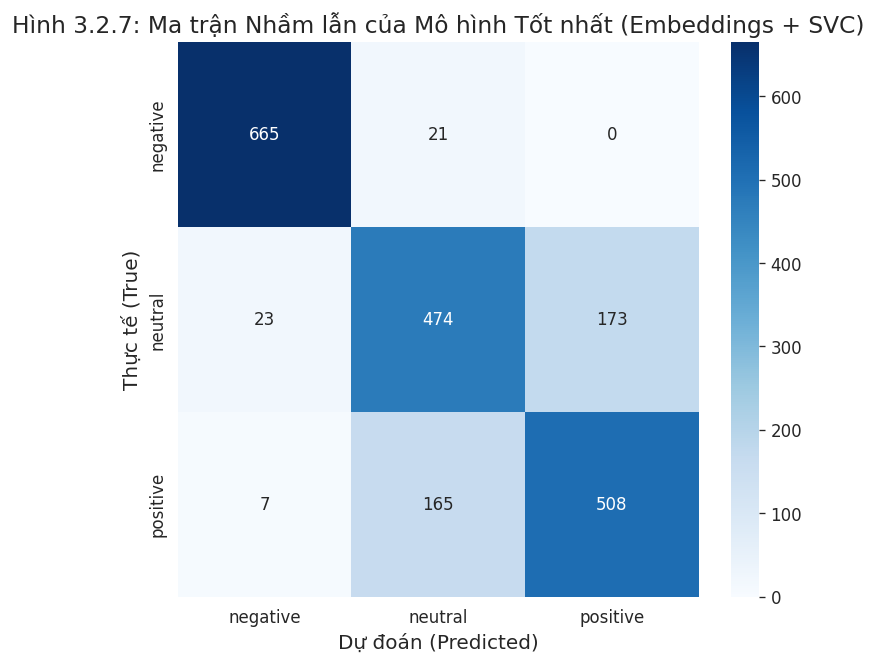


🎉 Toàn bộ quy trình đã hoàn tất. Bạn đã có đủ tư liệu và code cho báo cáo!


In [ ]:
# ====================================================================
# PHẦN 3: VECTOR HÓA VÀ KẾT QUẢ (CHƯƠNG 3)
# ====================================================================

print("\n--- 3. Thực nghiệm và Kết quả (Chương 3) ---")

# --- MỤC 3.1: TIỀN XỬ LÝ (Lý thuyết) VÀ VECTOR HÓA ---

# Vector hóa BoW (Mục 3.2)
print("\n[3.2.1] Vector hóa BoW...")
bow_vectorizer = CountVectorizer(tokenizer=vietnamese_tokenizer, ngram_range=(1, 2), max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)

# Vector hóa TF-IDF (Mục 3.2)
print("\n[3.2.2] Vector hóa TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(tokenizer=vietnamese_tokenizer, ngram_range=(1, 2), max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Vector hóa Embeddings (Mục 3.2)
print("\n[3.2.3] Sentence Embeddings (Quá trình này có thể mất 1-2 phút)...")
model_sbert = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
X_train_embed = model_sbert.encode(X_train.tolist(), show_progress_bar=True)
X_val_embed = model_sbert.encode(X_val.tolist(), show_progress_bar=True)


# --- MỤC 3.2: CHẠY THUẬT TOÁN VÀ ĐÁNH GIÁ ---
print("\n[3.2] Chạy các thuật toán (LR, SVC) cho 3 bộ đặc trưng...")

results = []
models = {
    'LR': LogisticRegression(random_state=42, max_iter=2000, solver='liblinear'),
    'SVC': LinearSVC(random_state=42, max_iter=3000)
}
vectorizers_map = {
    'BoW': (X_train_bow, X_val_bow),
    'TF-IDF': (X_train_tfidf, X_val_tfidf),
    'Embeddings': (X_train_embed, X_val_embed)
}

for vectorizer_name, (X_train_vec, X_val_vec) in vectorizers_map.items():
    for model_name, model_instance in models.items():
        model_instance.fit(X_train_vec, y_train)
        y_pred = model_instance.predict(X_val_vec)

        results.append({
            'Vectorizer': vectorizer_name,
            'Model': model_name,
            'F1_Macro': f1_score(y_val, y_pred, average='macro'),
            'Report': classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True),
            'Model_Instance': model_instance
        })

# --- MỤC 3.3: TỔNG HỢP VÀ SO SÁNH KẾT QUẢ ---
results_df = pd.DataFrame(results)

# Trích xuất các chỉ số chi tiết cho Bảng Báo cáo (Mục 3.2.6)
for metric in ['precision', 'recall', 'f1-score']:
    results_df[f'{metric.capitalize()}_Wgt'] = results_df['Report'].apply(lambda x: x['weighted avg'][metric])
results_df['Accuracy'] = results_df['Report'].apply(lambda x: x['accuracy'])

report_table = results_df[['Vectorizer', 'Model', 'Accuracy', 'F1_Macro', 'Precision_Wgt', 'Recall_Wgt']]
report_table = report_table.sort_values(by='F1_Macro', ascending=False).round(4)

print("\n------------------------------------------------------------------------------------------------")
print("🏆 BẢNG KẾT QUẢ SO SÁNH HIỆU SUẤT (Mục 3.2.6) 🏆")
print(report_table.to_markdown(index=False))
print("------------------------------------------------------------------------------------------------")


# --- HÌNH 3.3.1: BIỂU ĐỒ SO SÁNH (Mục 3.3) ---
plt.figure(figsize=(10, 6))
sns.barplot(data=report_table, x='Vectorizer', y='F1_Macro', hue='Model', palette='tab10')
plt.title('Hình 3.3.1: So sánh F1-score (Macro) giữa các Kỹ thuật Đặc trưng và Mô hình', fontsize=14)
plt.xlabel('Kỹ thuật Vector hóa', fontsize=12)
plt.ylabel('F1-score (Macro)', fontsize=12)
plt.show()


# --- HÌNH 3.2.7: MA TRẬN NHẦM LẪN CỦA MÔ HÌNH TỐT NHẤT ---
best_row = report_table.iloc[0]
best_vectorizer = best_row['Vectorizer']
best_model_name = best_row['Model']

best_result_record = results_df[(results_df['Vectorizer'] == best_vectorizer) & (results_df['Model'] == best_model_name)].iloc[0]
best_model_final = best_result_record['Model_Instance']

X_best_val = vectorizers_map[best_vectorizer][1]
y_pred_best = best_model_final.predict(X_best_val)

cm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Hình 3.2.7: Ma trận Nhầm lẫn của Mô hình Tốt nhất ({best_vectorizer} + {best_model_name})', fontsize=14)
plt.xlabel('Dự đoán (Predicted)', fontsize=12)
plt.ylabel('Thực tế (True)', fontsize=12)
plt.show()

print("\n🎉 Toàn bộ quy trình đã hoàn tất. Bạn đã có đủ tư liệu và code cho báo cáo!")